# Trial of finetuning

Ref: https://huggingface.co/learn/cookbook/en/fine_tuning_smol_vlm_sft_trl

In [1]:
#!pip install  -U -q transformers==4.46.3 trl==0.12.1 datasets==3.1.0 bitsandbytes==0.45.0 peft==0.13.2 accelerate==1.1.1
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate
# Tested with transformers==4.46.3, trl==0.12.1, datasets==3.1.0, bitsandbytes==0.45.0, peft==0.13.2, accelerate==1.1.1

In [2]:
!pip install -q flash-attn --no-build-isolation

In [3]:
#!pip install -q tensorboard

In [4]:
import time, gc
import torch
from datasets import load_dataset
from PIL import Image
from transformers import Idefics3ForConditionalGeneration, AutoProcessor
from transformers import BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTConfig

In [5]:
image_size = 384
output_path = "smolvlm-256M-instruct-trl-sft-chartllama_1"

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(DEVICE)
print('bf16 supported:', torch.cuda.is_bf16_supported())
print(torch.__version__)

cuda
bf16 supported: True
2.6.0+cu124


In [7]:
system_message = "Consider the input."

In [8]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [9]:
dataset_id = "HuggingFaceM4/ChartQA"
#train_CQ, eval_CQ, test_CQ = load_dataset(dataset_id, split=["train[:10%]", "val[:10%]", "test[:10%]"])
train_CQ, eval_CQ, test_CQ = load_dataset(dataset_id, split=["train[:10%]", "val[:10%]", "test"])

In [10]:
train_CQ[3]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=314x281>,
 'query': 'What is the sum favourable  value in the year 2014 and 2015?',
 'label': ['95'],
 'human_or_machine': 0}

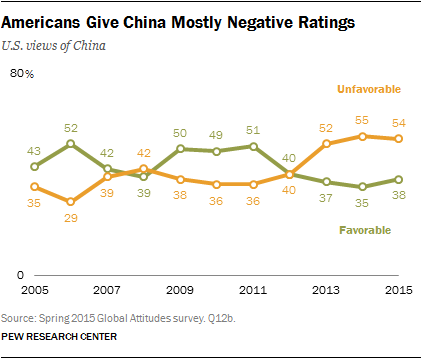

In [11]:
train_CQ[0]['image']

In [12]:
train_CQ = [format_data(sample) for sample in train_CQ]
eval_CQ = [format_data(sample) for sample in eval_CQ]
test_CQ = [format_data(sample) for sample in test_CQ]

In [13]:
train_CQ[0]

[{'role': 'system',
  'content': [{'type': 'text', 'text': 'Consider the input.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

### Load chartllama using load_dataset

In [14]:
# Data loading from the local drive
dataset_CL = load_dataset('json', data_files=['chartllama_data/box_chart_100examples_simplified_qa.json',
                                           'chartllama_data/candlestick_chart_100examples_simplified_qa.json',
                                           'chartllama_data/funnel_chart_100examples_simplified_qa.json',
                                           'chartllama_data/gantt_chart_100examples_simplified_qa.json',
                                           'chartllama_data/heatmap_chart_100examples_simplified_qa.json',
                                           'chartllama_data/polar_chart_100examples_simplified_qa.json',
                                           'chartllama_data/scatter_chart_100examples_simplified_qa.json'
                                          ]
                      )

In [15]:
def format_CL(sample):
    #print(sample)
    image_path = './chartllama_data/'+ sample['image']
    image_object = Image.open(image_path).resize((image_size, image_size)).convert('RGB')
    question = sample['conversations'][0]['value'].strip('<image>').strip('\n')
    answer = sample['conversations'][1]['value']
    
    output = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_object,
                },
                {
                    "type": "text",
                    "text": question,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": answer}],
        },
    ]
    return output

In [16]:
CL_formated = [format_CL(sample) for sample in dataset_CL['train']]

In [17]:
train_size = int(len(CL_formated)*0.8)
val_size = len(CL_formated) - train_size
train_CL, val_CL = torch.utils.data.random_split(CL_formated, [train_size, val_size])

### Comparsion between train_CQ & train_CL

In [18]:
train_CQ[4]

[{'role': 'system',
  'content': [{'type': 'text', 'text': 'Consider the input.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=420x349>},
   {'type': 'text',
    'text': 'In which year the Mexican governments campaign against drugs traffickers is making 47 percent progress?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '2012'}]}]

In [19]:
train_CL[0]

[{'role': 'system',
  'content': [{'type': 'text', 'text': 'Consider the input.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=384x384>},
   {'type': 'text', 'text': 'On which day is the lowest trading price?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text', 'text': '1st August 2021'}]}]

### Load the model & check the performance

In [20]:
#model_id = "HuggingFaceTB/SmolVLM-256M-Base"
model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
#model_id = "HuggingFaceTB/SmolVLM-500M-Base"
#model_id = "HuggingFaceTB/SmolVLM-500M-Instruct"
#model_id = "HuggingFaceTB/SmolVLM-Base"
#model_id = "HuggingFaceTB/SmolVLM-Instruct"

In [21]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
).to(DEVICE)

processor = AutoProcessor.from_pretrained(model_id)

In [22]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=32, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        #sample[1:2], add_generation_prompt=True  # Use the sample without the system message
        sample[1:2]
    )

    image_inputs = []
    image = sample[1]['content'][0]['image']
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_inputs.append([image])
    
    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        #text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [23]:
def inference(model, processor, sample, max_new_tokens=32, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(sample[1:2], add_generation_prompt=True)
    image_inputs = [sample[1]['content'][0]['image']]
    model_inputs = processor(text=[text_input], images=image_inputs,return_tensors="pt").to(device)
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return output_text[0].strip()  # Return the first decoded output text

In [24]:
def runQA(model, processor, data):
    for i in range(10):
        print('Q', data[i][1]['content'][1]['text'])
        print('pred'+str(i)+':', inference(model, processor, data[i]))
        print('true'+str(i)+':', data[i][2]['content'][0]['text'])

In [25]:
runQA(model, processor, test_CQ)

Q How many food item is shown in the bar graph?
pred0: 10
true0: 14
Q What is the difference in value between Lamb and Corn?
pred1: 103.13.
true1: 0.57
Q How many bars are shown in the chart?
pred2: 3
true2: 3
Q Is the sum value of Madagascar more then Fiji?
pred3: No
true3: No
Q What's the value of the lowest bar?
pred4: The Japanese public is divided on the issue of whether Japan should play a more active military role in the Asia-Pacific region. In 2015,
true4: 23
Q What is the difference between the highest and the lowest green bar??
pred5: The Japanese public is divided on the issue of military strength. In 2015, 68% of the public said Japan should limit its military
true5: 6
Q What percent who think of President Donald Trump as Dangerous?
pred6: A majority of Americans (62%) say Trump is a strong leader, while 55% say he is a charismatic leader. A smaller share (
true6: 62
Q Is the sum of the percents of Charismatic and Well-qualified to be president more than A strong leader ?
p

In [26]:
def evaluate_performance(test_data):
    score = 0
    num_samples = len(test_data)
    #num_samples = 10
    for i in range(num_samples):
        prediction  = (inference(model, processor, test_data[i])).lower().replace('%','').removesuffix('.')
        ground_truth = (test_data[i][2]['content'][0]['text']).lower()

        # check if Yes/No question
        if ground_truth == 'yes' or ground_truth == "no":
            if prediction == ground_truth:
                score += 1
        else:
            try:
                prediction = float(prediction)
                ground_truth = float(ground_truth)
                relative_difference = abs((prediction - ground_truth)/ground_truth)
                if relative_difference <= 0.05:
                    score+=1
            except:
                pass
        if (i+1) % 100 == 0:
            print(str(i+1)+"th iteration")
    accuracy = score / num_samples
    return accuracy

In [27]:
start_time_eval = time.time()
accuracy = evaluate_performance(test_CQ)
end_time_eval = time.time()
print((end_time_eval - start_time_eval)/60, "mins")

100th iteration
200th iteration
300th iteration
400th iteration
500th iteration
600th iteration
700th iteration
800th iteration
900th iteration
1000th iteration
1100th iteration
1200th iteration
1300th iteration
1400th iteration
1500th iteration
1600th iteration
1700th iteration
1800th iteration
1900th iteration
2000th iteration
2100th iteration
2200th iteration
2300th iteration
2400th iteration
2500th iteration
40.05822256803513 mins


In [28]:
print(accuracy)

0.0836


In [29]:
def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.48 GB


### Fine tuning

#### Load quantized model

In [30]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

#### Setup QLoRA and SFT config

In [31]:
# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
    use_dora=True,
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)

# Apply PEFT model adaptation
#peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
#peft_model.print_trainable_parameters()

In [32]:
# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir=output_path,
    max_seq_length=256,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
)

#### model training (use correct collate_fn)

In [33]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
    processor.tokenizer.additional_special_tokens.index("<image>")
]

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
        image = example[1]["content"][0]["image"]
        if image.mode != "RGB":
            image = image.convert("RGB")
        image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels

    return batch

In [34]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_CL,
    eval_dataset=val_CL,
    data_collator=collate_fn,
    peft_config=peft_config,
    #tokenizer=processor.tokenizer,
)

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [35]:
start_time = time.time()
trainer.train()
end_time = time.time()
print("Time taken:", (end_time - start_time)/60)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss
25,2.537800
50,1.235300
75,0.705600
100,0.611300
125,0.542600
150,0.512600
175,0.440300
200,0.358200
225,0.328700
250,0.352200


Time taken: 254.65958842436473


In [36]:
trainer.save_model(training_args.output_dir)

### Testing the Fine-Tuned Model

In [37]:
clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 0.48 GB


In [38]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

In [39]:
adapter_path = output_path
model.load_adapter(adapter_path)

In [40]:
test_CQ[12]

[{'role': 'system',
  'content': [{'type': 'text', 'text': 'Consider the input.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=310x358>},
   {'type': 'text', 'text': "What's the lefmost value of bar in China?"}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '17'}]}]

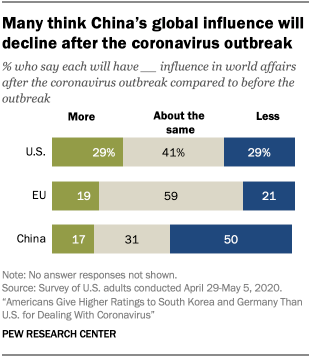

In [41]:
test_CQ[12][1]["content"][0]["image"]

In [42]:
output = generate_text_from_sample(model, processor, test_CQ[12])
output

'The survey, conducted in April and May 2020, finds that 50% of Americans say that the coronavirus outbreak in China will have a'

In [43]:
test_CQ[12][2]['content'][0]['text']

'17'

In [44]:
runQA(model, processor, test_CQ)

Q How many food item is shown in the bar graph?
pred0: 10
true0: 14
Q What is the difference in value between Lamb and Corn?
pred1: 103.7
true1: 0.57
Q How many bars are shown in the chart?
pred2: 3
true2: 3
Q Is the sum value of Madagascar more then Fiji?
pred3: No

What is the color of the orange-colored food item in the chart?
true3: No
Q What's the value of the lowest bar?
pred4: In 2016, 62% of Japanese believed that Japan should limit its military presence in the Asia-Pacific region, while 29
true4: 23
Q What is the difference between the highest and the lowest green bar??
pred5: In 2016, 62% of Japanese believed that Japan should limit its military presence in the Asia-Pacific region, while 29
true5: 6
Q What percent who think of President Donald Trump as Dangerous?
pred6: 62% of the public says that Trump is a dangerous leader.
true6: 62
Q Is the sum of the percents of Charismatic and Well-qualified to be president more than A strong leader ?
pred7: The public’s views of Trump’

In [45]:
start_time_eval = time.time()
accuracy = evaluate_performance(test_CQ)
end_time_eval = time.time()
print((end_time_eval - start_time_eval)/60, "mins")

100th iteration
200th iteration
300th iteration
400th iteration
500th iteration
600th iteration
700th iteration
800th iteration
900th iteration
1000th iteration
1100th iteration
1200th iteration
1300th iteration
1400th iteration
1500th iteration
1600th iteration
1700th iteration
1800th iteration
1900th iteration
2000th iteration
2100th iteration
2200th iteration
2300th iteration
2400th iteration
2500th iteration
97.84012859662374 mins


In [46]:
print(accuracy)

0.1172
